Будем создавать универсальную модель Neural Style Transfer, которая в зависимости от подаваемого в неё параметра стиля, умела:
1. Переносить просто 1 стиль на изображение
2. Переносить 2 стиля одновременно на изображение
3. Переносить 2 стиля на изображение, деля его пополам по вертикали или горизонтали

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import copy

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Вспомогательные функции:

In [3]:
def image_loader(image_path, image_size=128):
    """Принимает на вход путь и размеры изображения,
    возвращает преобразованное под нужный размер изображение,
    с добавленной осью для батчей, в виде тензора, переведенного на device"""
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])  
    
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)


def imshow(tensor, title=None):
    """Принимает на вход изображение в виде тензора, 
    преобразует его в картинку и рисует"""
    
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    #plt.show();
    
    
def get_input_optimizer(input_img):
    """добавляет содержимое тензора изображения в список изменяемых оптимизатором параметров"""
    optimizer = optim.LBFGS([input_img.requires_grad_()]) 
    return optimizer


def gram_matrix(input):
    """Принимает на вход тензор, вычисляет матрицу Грама, 
    возвращает усредненные значения"""
        
    batch_size, f_map_num, h, w = input.size() 
    # batch_size=1, f_map_num - количество фича мапов, h, w - размерность фича мапов

    features = input.view(batch_size * f_map_num, h * w)
    G = torch.mm(features, features.t())
        
    return G.div(batch_size * f_map_num * h * w)

Классы для нормализации, content и style loss:

In [4]:
class Normalization(nn.Module):
    """Нормализация изображения под заданные mean и std. 
    Наследуем от nn.Module, тк этот класс будет слоем в модели"""
    def __init__(self, mean, std):
        super(Normalization, self).__init__()            
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)
            
    def forward(self, img):
        return (img - self.mean) / self.std


class StyleLoss(nn.Module):
    """Класс для ф-ии потерь между style image и input image,
    вычисляет среднеквадратичное отклонение матриц Грама. Наследуем от nn.Module, тк класс
    будет слоем в модели."""
    
    def __init__(self, target_feature, style, mask_order=None):
        super(StyleLoss, self).__init__()
        # при инициализации, в качестве self.target будут сохраняться матрицы грамма для 
        # style_img, после сверточных слоев с разными размерностями на разных слоях модели.
        self.target = gram_matrix(target_feature).detach()
        self.loss = F.mse_loss(self.target, self.target) # начальная инициализация лосса
        self.style = style # тип стиля отображения: один style_img или два
        self.mask_order = mask_order # очередность маски - первая или вторая, если 2 стиля
    
    def forward(self, input):
        def make_mask(self, input):
            # ф-я для создания масок для случая, когда мы делаем 2 стиля для разных частей картинки, 
            mask = torch.ones_like(input) # делаем маску из единиц такой же размерности, как входной тензор
            if self.style == 'split_h': # если сплит картинки на 2 стиля по горизонтали 
                h = input.size()[2]            
                if self.mask_order == 1: 
                    mask[:, :, h//2:, :] -= 1 # создаем верхнюю, заполняя нулями низ матрицы
                else:
                    mask[:, :, :h//2, :] -= 1 # или нижнюю маску, заполняя нулями верх матрицы

            elif self.style == 'split_v': # если сплит на 2 картинки по вертикали
                h = input.size()[3]
                if self.mask_order == 1:
                    mask[:, :, :, h//2:] -= 1 # создаем левую
                else:
                    mask[:, :, :, :h//2] -= 1 # или правую маску

            return mask
                            
        tmp_input = input.clone() # клонируем исходный тензор, чтобы не менять его   
        if self.style == 'split_h' or 'split_v': # если стиль заполнения - сплит картинки           
            mask = make_mask(self, tmp_input) # содаем маску
            tmp_input = tmp_input * mask # поэлементно умножаем входной тензор на маску
            
        G = gram_matrix(tmp_input) # считаем матрицу Грама для input_img после свертночного\ых слоя\ев
        # считаем style_loss между style_img и input_img после одних и тех же слоев, сохраняем в self.loss
        self.loss = F.mse_loss(G, self.target)
        return input
    

class ContentLoss(nn.Module):
    """ Класс для ф-ии потерь между content image и input image,
    вычисляет среднеквадратичное отклонение"""
    
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach() # это константа, градиент вычислять не нужно
        self.loss = F.mse_loss(self.target, self.target) # начальная инициализация

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) 
        # считаем MSE между content и input image после одних и тех же слоев
        return input

In [5]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                content_img, style_img, 
                                style_img2=None, style='single'):
        
    # слои, для которых мы будем считать ошибки
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    
    cnn = copy.deepcopy(cnn) # создаем копию поданной модели, чтобы не менять исходную
    normalization = Normalization(normalization_mean, normalization_std).to(device)
        
    content_losses = []
    style_losses = []
    style_losses2 = []
    
    model = nn.Sequential(normalization) # первым слоем в нашей новой модели будет нормализация

    i = 0  # счетчик для нумерации сверточных слоев
    # пробегам по модели и "выдергиваем" из неё нужные нам слои
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer) # добавляем слой в нашу новую модель

        if name in content_layers: # если мы встретили слой, для которого мы считаем content_loss
            target = model(content_img).detach() # проводим content_img через нашу модель
            content_loss = ContentLoss(target) # инициализируем объект класса ContentLoss
            model.add_module("content_loss_{}".format(i), content_loss) # добавляем его в модель
            content_losses.append(content_loss) # так же добавляем его в список контент лоссов

        if name in style_layers: # если мы встретили слой, для которого мы считаем style_loss
            target_feature = model(style_img).detach() # проводим style_img через нашу модель
            mask_order=1 # это будет первый (или единственный) стиль
            # инициализируем объект класса StyleLoss
            style_loss = StyleLoss(target_feature, style, mask_order)
            
            if style is not 'single': # если стиль любой, кроме single
                target_feature2 = model(style_img2).detach() # проводим style_img2 через модель 
                mask_order = 2 # это будет второй стиль
                # инициализируем еще один объект класса StyleLoss с вторым стилем
                style_loss2 = StyleLoss(target_feature2, style, mask_order)
                # добавляем этот объект в модель и в список лоссов
                model.add_module("style_loss_2_{}".format(i), style_loss2)
                style_losses2.append(style_loss2)
                
            # добавляем класс лосса первого стиля в модель и в список лоссов    
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
               
    # ищем индекс последнего слоя с content или style loss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    # выбрасываем все уровни после последенего style loss или content loss
    model = model[:(i + 1)]

    return model, style_losses, style_losses2, content_losses

In [6]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, input_img, style_img, style_img2=None, num_steps=500,
                        style_weight=100000, style_weight_сoef=1, content_weight=1, 
                        style='single', silent=False):
        """style_weight - вес первого стиля
        style_weight_сoef - коэффициент весов, если 2 стиля. Если style_weight_сoef больше 0.5, 
        второго стиля будет меньше, если меньше 0.5, то превого"""
        
        # сформируем нашу модель
        model, style_losses, style_losses2, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, content_img, style_img, style_img2, style)

        # инициализируем оптимизатор, отправив в него input_img, чтобы по ней считался градиент
        optimizer = get_input_optimizer(input_img)
        print('Творится магия переноса стиля, потерпите...')
        run = [0] # счетчик итераций
        while run[0] <= num_steps:

            def closure():
                """Ф-я, возвращающая обобщенный loss, для передачи в оптимизатор"""
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                # проводим input_img через модель (в том числе и через ф-ии потерь)
                model(input_img)

                style_score = 0
                style_score2 = 0
                content_score = 0
                # пробегаем по ранее сохраненным спискам лоссов, накапливаем потери
                for sl in style_losses:
                    style_score += sl.loss
                for sl2 in style_losses2:
                    style_score2 += sl2.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ошибки
                style_score = style_score * style_weight * style_weight_сoef
                style_score2 = style_score2 * style_weight * (1 - style_weight_сoef)
                content_score *= content_weight
                # вычисляем суммарный лосс
                loss = style_score + style_score2 + content_score
                # вычисляем градиент
                loss.backward()
                
                style_score = style_score + style_score2
                run[0] += 1
                if silent is not True: # если не режим тишины, выводим результаты
                    if run[0] % 100 == 0:
                        print("run {}:".format(run))
                        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                            style_score.item(), content_score.item()))
                        print()

                return loss
            # делаем шаг оптимизатора по input_img, изменяя её
            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img

In [7]:
#Т.к. vgg натренирована на ImageNet, надо отнормировать наши данные так же
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [8]:
# возьмем предобученную vgg19
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
image_size = (512, 512) # размер, под который будут изменяться изображения

В качестве контент изображений возьмем скриншоты из отличной лекции по NST Кирилла Голубева 

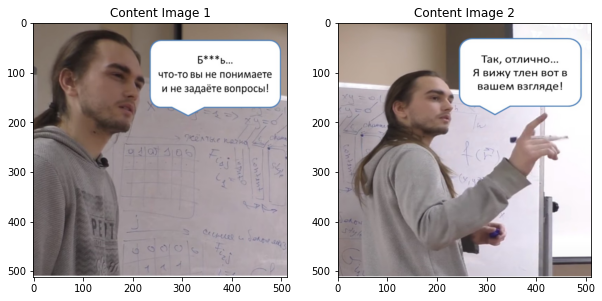

In [10]:
content_img1 = image_loader("images/1.jpg", image_size)
content_img2 = image_loader("images/2.jpg", image_size)
plt.figure(figsize=(10, 6)) 
plt.subplot(1, 2, 1)
imshow(content_img1, title='Content Image 1')
plt.subplot(1, 2, 2)
imshow(content_img2, title='Content Image 2')

Для стилей выберем картины уличных художников Алексея Луки, Гоши Укора и Константина Данилова

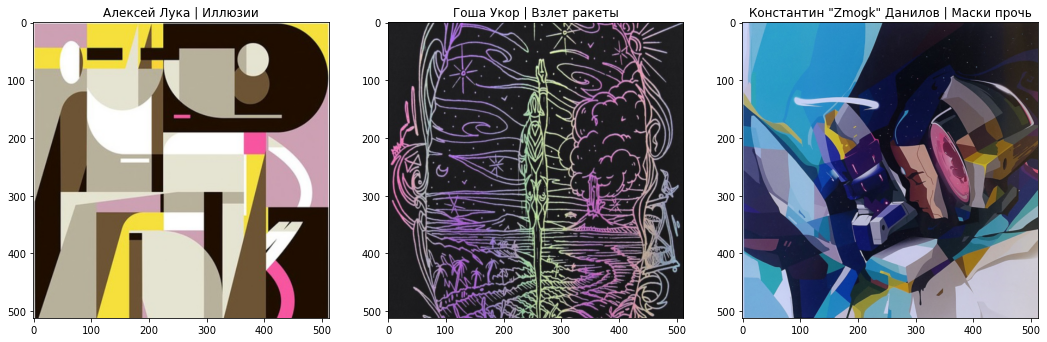

In [11]:
style_img1 = image_loader("images/styles/luka.jpg", image_size)
style_img2 = image_loader("images/styles/rocket.jpg", image_size)
style_img3 = image_loader("images/styles/masks.jpg", image_size)
plt.figure(figsize=(18, 12)) 
plt.subplot(1, 3, 1)
imshow(style_img1, title='Алексей Лука | Иллюзии')
plt.subplot(1, 3, 2)
imshow(style_img2, title='Гоша Укор | Взлет ракеты')
plt.subplot(1, 3, 3)
imshow(style_img3, title='Константин "Zmogk" Данилов | Маски прочь')

Единственный стиль - Zmogk

In [57]:
input_img = content_img2.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img2, input_img, style_img3, num_steps=500,
                            style='single')

Творится магия переноса стиля, потерпите...
run [100]:
Style Loss : 18.324802 Content Loss: 11.255556

run [200]:
Style Loss : 5.164706 Content Loss: 9.712237

run [300]:
Style Loss : 2.701751 Content Loss: 8.765826

run [400]:
Style Loss : 2.006168 Content Loss: 8.208070

run [500]:
Style Loss : 2.119092 Content Loss: 8.058781



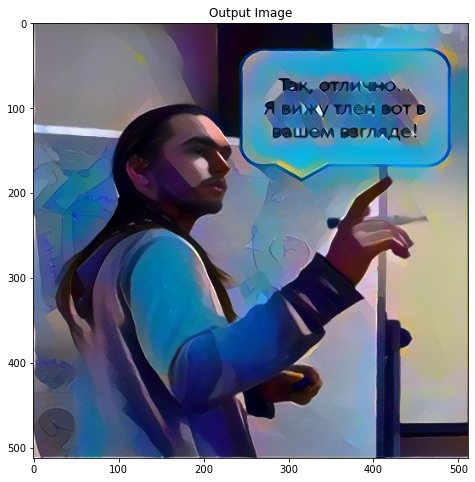

In [58]:
plt.figure(figsize=(12, 8)) 
imshow(output, title='Output Image')

Отключим вывод истории обучения для лучшей читаемости.

2 стиля, сплит по вертикали. Лука + Zmogk

In [16]:
input_img = content_img1.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img1, input_img, style_img1, style_img3, num_steps=500,
                            style='split_v', silent=True, style_weight=200000, style_weight_сoef=0.5)

Творится магия переноса стиля, потерпите...


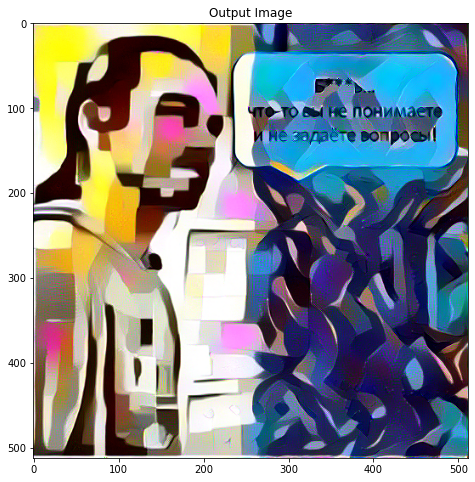

In [17]:
plt.figure(figsize=(12, 8))
imshow(output, title='Output Image')

2 стиля, сплит по горизонтали. Укор + Zmogk

In [12]:
input_img = content_img2.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img2, input_img, style_img2, style_img1, num_steps=500,
                            style='split_h', silent=True, style_weight=200000, style_weight_сoef=0.5)

Творится магия переноса стиля, потерпите...


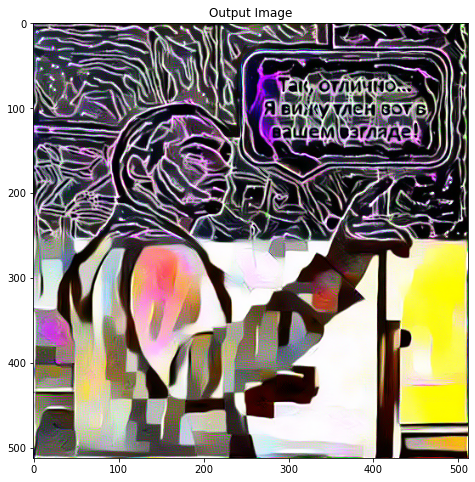

In [13]:
plt.figure(figsize=(12, 8))
imshow(output, title='Output Image')

2 стиля одновременно, c равными весами, Лука + Укор.

In [93]:
input_img = content_img2.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img2, input_img, style_img1, style_img2, num_steps=500,
                            silent=True, style_weight_сoef=0.5, style='both')

Творится магия переноса стиля, потерпите...


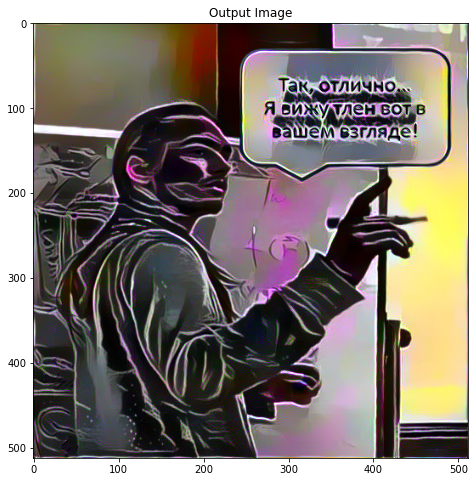

In [94]:
plt.figure(figsize=(12, 8)) 
imshow(output, title='Output Image')

2 стиля одновременно с бОльшим весом у первого, Лука + Укор.

In [95]:
input_img = content_img2.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img2, input_img, style_img1, style_img2, num_steps=500,
                            silent=True, style_weight_сoef=0.8, style='both')

Творится магия переноса стиля, потерпите...


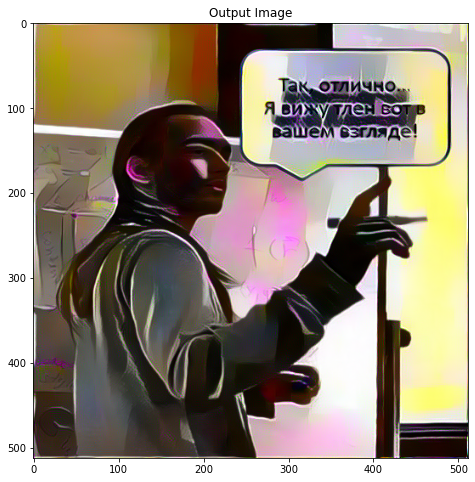

In [96]:
plt.figure(figsize=(12, 8)) 
imshow(output, title='Output Image')

2 стиля одновременно с бОльшим весом у второго, Лука + Укор.

In [97]:
input_img = content_img2.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img2, input_img, style_img1, style_img2, num_steps=500,
                            silent=True, style_weight_сoef=0.2, style='both')

Творится магия переноса стиля, потерпите...


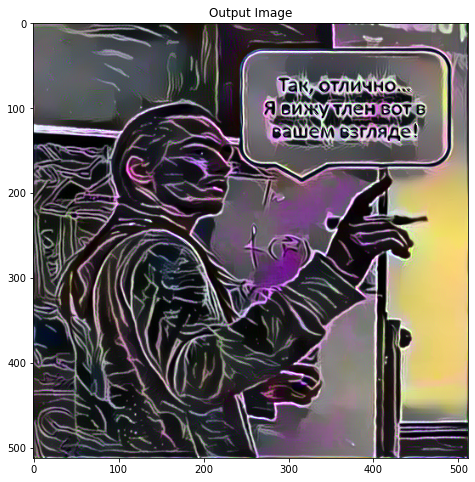

In [98]:
plt.figure(figsize=(12, 8)) 
imshow(output, title='Output Image')

In [92]:
# save image
image = input_img.cpu().clone()   
image = image.squeeze(0)
image = transforms.ToPILImage()(image)
image.save('output.jpg')